In [1]:
from backward_process.generating import Generate
from save_plot.plotter import PlotCritical
from initial_distributions.two_deltas import GenerateTwoDeltas
from neural_network.training_nn import TrainModel
from neural_network.neural_network import FeedForward

import matplotlib.pyplot as plt
import torch 

#device = torch.device(f'cuda:{torch.cuda.current_device()}') if torch.cuda.is_available() else 'cpu'

In [2]:
ndata = 1000
timesteps = 1000
plt.style.use('bmh')

In [3]:
loss_hist_train, val_hist_train, scaler, test_loss = TrainModel(timesteps, ndata, initial_distribution=GenerateTwoDeltas)

Generating two deltas distribution with 1000 data points...
Beginning training...


In [5]:
model = FeedForward(input_size=2,output_size=1,n_hidden_layers=2,depht=200)
state_dict = torch.load('model.pth')
model.load_state_dict(state_dict)
model.eval();

In [6]:
Generate(timesteps, ndata, model=model, scaler=scaler)

Backward process started...


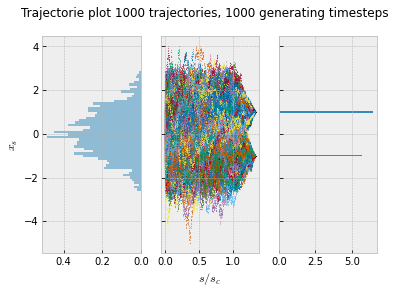

In [7]:
import numpy as np
import pandas as pd


name = str(ndata)+" trajectories, "+str(timesteps)+" generating timesteps"

critical_time = timesteps - 246

reduced_timesteps = np.arange(timesteps)/critical_time

fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].set_ylabel(r"$x_{s}$")
ax[1].set_xlabel(r"$s/s_c$")
fig.suptitle("Trajectorie plot "+name)

#scatter plot

distros = pd.read_csv("data/generated_data.csv", header=None).to_numpy()

for i in range(distros.shape[1]):

    ax[1].scatter(reduced_timesteps, distros[:,i], alpha = 0.5, s=0.3)

#histograms

hist0 = distros[0,:]
hist2= distros[-1,:]

ax[0].hist(hist0, bins=50, orientation='horizontal', density=True, alpha=0.5)
ax[2].hist(hist2, bins=25, orientation='horizontal', density=True)

ax[0].invert_xaxis()

In [32]:
from forward_process.generate_noised_data import BetaSchedule
from scipy.integrate import simps

beta = BetaSchedule(timesteps)

def Theta(time):

    reduced_beta = beta[:time]

    return np.exp(-0.5*simps(reduced_beta, x=None, dx=1))


def GetCorrelations(array):

    corr = (array**2).mean(axis=1) - (array.mean(axis=1))**2

    return corr

In [40]:
delta = np.zeros(timesteps)

for i in range(1,timesteps):
    
    delta[i] = 1 - Theta(i)**2


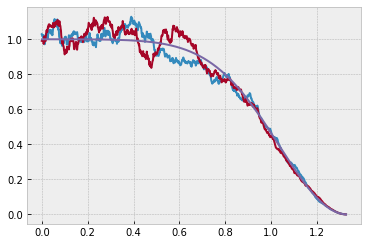

In [44]:

distros_c1 = distros[:, distros[-1,:] >= 0]
distros_c2 = distros[:, distros[-1,:] < 0]

fig_corr, ax_corr = plt.subplots()
correlations1 = GetCorrelations(distros_c1)
correlations2 = GetCorrelations(distros_c2)

ax_corr.plot(reduced_timesteps, correlations1)
ax_corr.plot(reduced_timesteps, correlations2)
ax_corr.plot(timesteps/critical_time-reduced_timesteps, delta)

In [74]:
from scipy.stats import entropy

def MSE(distros):

    mse = np.zeros(timesteps)

        #entropies = np.zeros(timesteps)

    delta_histogram, delta_bins = np.histogram(distros[-1], bins=50)

    delta_n_histogram = delta_histogram/delta_histogram.sum()

    for i in range(timesteps):

        height, bins = np.histogram(distros[i], bins=50)
        n_height = height/height.sum()
        mse[i] = ((delta_n_histogram - n_height)**2).mean()

            #entropies[i] = entropy(n_height, delta_n_histogram, base=2)
        
    return np.where(mse==np.max(mse))[0][-1]



In [ ]:
ndata_list = [10, 100, 1000, 10000, 100000]

losses = np.zeros(len(ndata_list))

index_maximum = np.zeros(len(ndata_list))

for i in range(len(ndata_list)):

    ndata = ndata_list[i]
        
    loss_hist_train, val_hist_train, scaler, test_loss = TrainModel(timesteps, ndata, initial_distribution=GenerateTwoDeltas)
        
    model = FeedForward(input_size=2,output_size=1,n_hidden_layers=2,depht=200)
    state_dict = torch.load('model.pth')
    model.load_state_dict(state_dict)
    model.eval();

    Generate(timesteps, ndata, model=model, scaler=scaler)

    distros = pd.read_csv("data/generated_data.csv", header=None).to_numpy()

    losses[i] = test_loss
        
    index_maximum[i] = MSE(distros)
    

Generating two deltas distribution with 10 data points...
Beginning training...
Backward process started...
Generating two deltas distribution with 100 data points...
Beginning training...
Backward process started...
Generating two deltas distribution with 1000 data points...
Beginning training...
Backward process started...
Generating two deltas distribution with 10000 data points...
Beginning training...
Backward process started...
Generating two deltas distribution with 100000 data points...
Beginning training...
